In [1]:
# Install required packages
!pip install lifelines scikit-survival pandas numpy seaborn matplotlib scikit-learn

# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import CoxPHFitter, KaplanMeierFitter
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, classification_report

Defaulting to user installation because normal site-packages is not writeable
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
   ---------------------------------------- 0.0/832.6 kB ? eta -:--:--
   ---------------------------------------- 832.6/832.6 kB 9.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/11.1 MB ? eta -:--:--
   ------- -------------------------------- 2.1/11.1 MB 9.0 MB/s eta 0:00:01
   ------------- -------------------------- 3.7/11.1 MB 8.7 MB/s eta 0:00:01
   ----------------- ---------------------- 5.0/11.1 MB 7.7 MB/s eta 0:00:01
   --------------------- ------------------ 6.0/11.1 MB 7.1 MB/s eta 0:00:01
   ----------------------- ---------------- 6.6/11.1 MB 6.8 MB/s eta 0:00:01
   ------------------------- -------------- 7.1/11.1 MB 5.9 MB/s eta 0:00:01
   -------------------------- ------------- 7.3/11.1 MB 5.3 MB/s eta 0:00:01
   ---------------------------- ----------- 7.9/11.1 MB 4.8 

  DEPRECATION: Building 'autograd-gamma' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'autograd-gamma'. Discussion can be found at https://github.com/pypa/pip/issues/6334


In [3]:
# Load dataset
df = pd.read_csv(r"C:\Users\Revathi\Documents\MLProjects\TelecomCustomerChurnPrediction\WA_Fn-UseC_-Telco-Customer-Churn.csv")

# Replace spaces in column names
df.columns = df.columns.str.replace(" ", "_")

# Drop customerID
df.drop("customerID", axis=1, inplace=True)

# Convert TotalCharges to numeric
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors='coerce')

# Fill missing TotalCharges with MonthlyCharges * tenure
df["TotalCharges"] = df["TotalCharges"].fillna(df["MonthlyCharges"] * df["tenure"])

# Encode target: churn (1 = Yes, 0 = No)
df["Churn_flag"] = df["Churn"].map({"Yes": 1, "No": 0})

# Event: Churn (1 = Event Occurred), Duration: tenure
df["event"] = df["Churn_flag"]
df["duration"] = df["tenure"]


In [4]:
# Drop redundant columns
df.drop(columns=["Churn", "tenure"], inplace=True)

# Binary encoding for Yes/No
binary_cols = df.nunique()[df.nunique() == 2].keys().tolist()
binary_cols.remove("Churn_flag")
binary_map = {"Yes": 1, "No": 0}
df[binary_cols] = df[binary_cols].replace(binary_map)

# One-hot encoding for remaining categoricals
df = pd.get_dummies(df, drop_first=True)

# Standardize numeric columns
scaler = StandardScaler()
num_cols = ["MonthlyCharges", "TotalCharges"]
df[num_cols] = scaler.fit_transform(df[num_cols])

df.head()

C:\Users\Revathi\AppData\Local\Temp\ipykernel_26608\4123937330.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[binary_cols] = df[binary_cols].replace(binary_map)


,SeniorCitizen,Partner,Dependents,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn_flag,event,duration,...,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,1,0,0,1,-1.160323,-0.992611,0,0,1,...,False,False,False,False,False,False,False,False,True,False
1,0,0,0,1,0,-0.259629,-0.172165,0,0,34,...,False,False,False,False,False,True,False,False,False,True
2,0,0,0,1,1,-0.362660,-0.958066,1,1,2,...,False,False,False,False,False,False,False,False,False,True
3,0,0,0,0,0,-0.746535,-0.193672,0,0,45,...,True,False,False,False,False,True,False,False,False,False
4,0,0,0,1,1,0.197365,-0.938874,1,1,2,...,False,False,False,False,False,False,False,False,True,False


#### The Kaplan-Meier Estimator (KME) is a non-parametric maximum likelihood estimator of the survival function.It is a non-parametric estimate of the survival function that does not make any assumptions about the underlying distribution of the data. The Kaplan-Meier curve is used to estimate the survival function from data that are censored, truncated, or have missing value


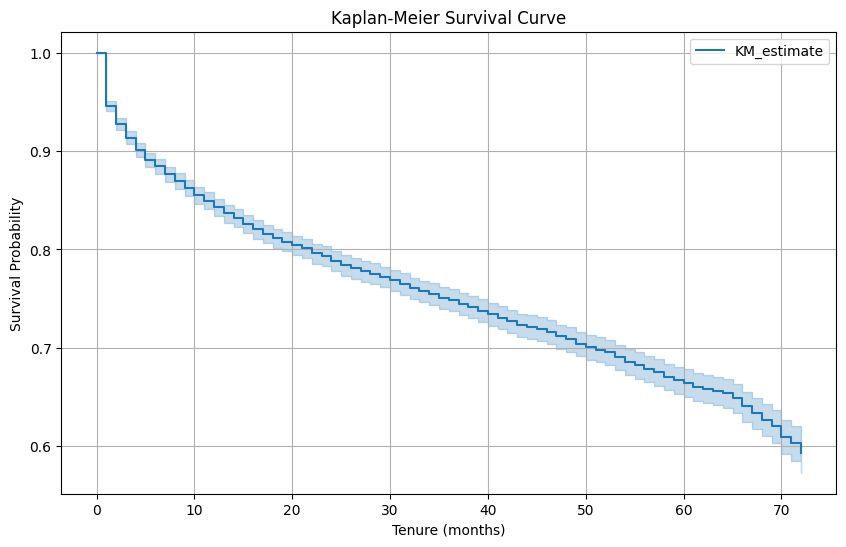

In [6]:
# Kaplan-Meier Survival Curve
kmf = KaplanMeierFitter()
kmf.fit(df["duration"], event_observed=df["event"])

plt.figure(figsize=(10, 6))
kmf.plot()
plt.title("Kaplan-Meier Survival Curve")
plt.xlabel("Tenure (months)")
plt.ylabel("Survival Probability")
plt.grid(True)
plt.show()

<lifelines.CoxPHFitter: fitted with 7043 total observations, 5174 right-censored observations>
             duration col = 'duration'
                event col = 'event'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 7043
number of events observed = 1869
   partial log-likelihood = -13928.34
         time fit was run = 2025-07-09 15:51:40 UTC

---
                                       coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                              
SeniorCitizen                          0.05      1.05      0.05           -0.05            0.14                0.95                1.15
Partner                               -0.31      0.73      0.04           -0.39           -0.23                0.67                0.80
Dependents                            -0.15      0.86      0.05           -0.25           -0.05                0.78                0.95
PhoneService                           0.11      1.12      0.10           -0.08            0.31                0.92                1.36
PaperlessBilling                       0.18      1.20      0.04            0.10            0.27                1.10                1.31
MonthlyCharges                         0.09      1.09      0.03            0.02            0.15                1.02                1.17
TotalCharges                          -0.85      0.43      0.03           -0.91           -0.79                0.40                0.45
gender_Male                           -0.03      0.97      0.04           -0.11            0.04                0.89                1.04
MultipleLines_No phone service        -0.11      0.90      0.10           -0.31            0.08                0.74                1.09
MultipleLines_Yes                     -0.15      0.86      0.04           -0.24           -0.07                0.79                0.94
InternetService_Fiber optic            0.47      1.60      0.05            0.37            0.58                1.45                1.78
InternetService_No                    -0.22      0.80      0.09           -0.39           -0.06                0.68                0.95
OnlineSecurity_No internet service    -0.22      0.80      0.09           -0.39           -0.06                0.68                0.95
OnlineSecurity_Yes                    -0.43      0.65      0.05           -0.52           -0.33                0.59                0.72
OnlineBackup_No internet service      -0.22      0.80      0.09           -0.39           -0.06                0.68                0.95
OnlineBackup_Yes                      -0.31      0.73      0.04           -0.40           -0.23                0.67                0.80
DeviceProtection_No internet service  -0.22      0.80      0.09           -0.39           -0.06                0.68                0.95
DeviceProtection_Yes                  -0.18      0.83      0.05           -0.27           -0.09                0.76                0.91
TechSupport_No internet service       -0.22      0.80      0.09           -0.39           -0.06                0.68                0.95
TechSupport_Yes                       -0.34      0.71      0.05           -0.43           -0.24                0.65                0.79
StreamingTV_No internet service       -0.22      0.80      0.09           -0.39           -0.06                0.68                0.95
StreamingTV_Yes                        0.04      1.04      0.04           -0.05            0.12                0.95                1.13
StreamingMovies_No internet service   -0.22      0.80      0.09           -0.39           -0.06                0.68                0.95
StreamingMovies_Yes                    0.01      1.01      0.04           -0.08            0.10                0.92                1.10
Contract_One year                

<Axes: xlabel='log(HR) (95% CI)'>

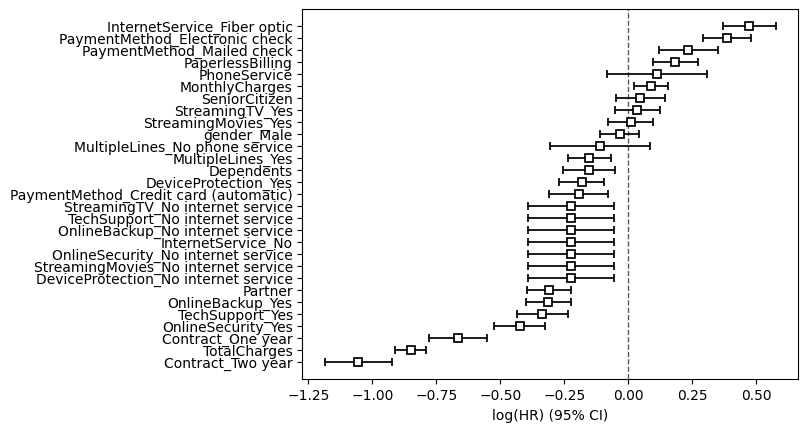

In [8]:
from sklearn.feature_selection import VarianceThreshold
from lifelines import CoxPHFitter

# Step 1: Select only relevant features
X_vars = df.drop(columns=["Churn_flag", "event", "duration"])

# Step 2: Remove low-variance features
selector = VarianceThreshold(threshold=0.01)
X_reduced = selector.fit_transform(X_vars)
X_cols = X_vars.columns[selector.get_support()]
filtered_df = pd.DataFrame(X_reduced, columns=X_cols)

# Step 3: Reconstruct the Cox model input dataframe
cox_df = pd.concat([filtered_df, df[["duration", "event"]].reset_index(drop=True)], axis=1)

# Step 4: Fit Cox model with regularization
cph = CoxPHFitter(penalizer=0.1)  # Add L2 penalization to avoid singularity
cph.fit(cox_df, duration_col="duration", event_col="event")
cph.print_summary()

# Step 5 (Optional): Plot top features
cph.plot()


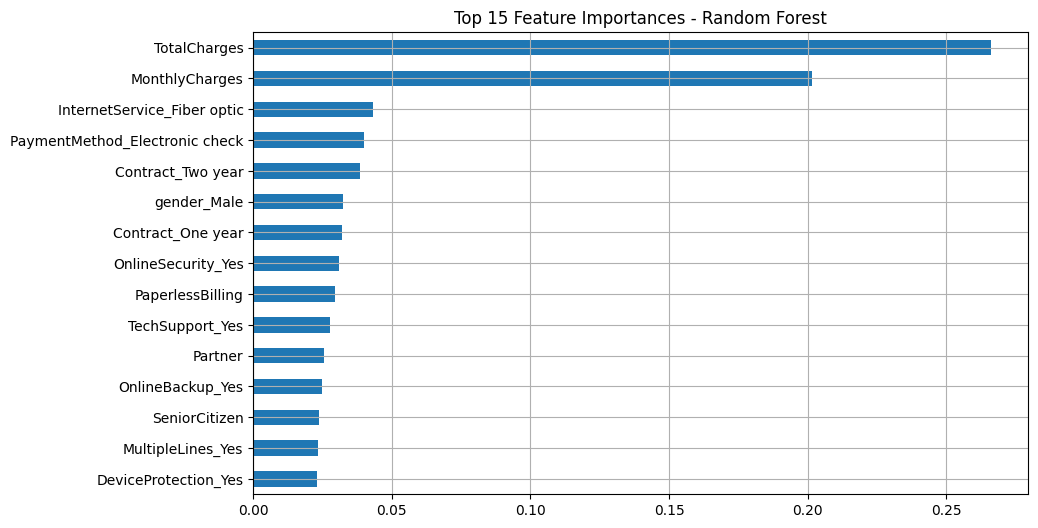

In [9]:
# Prepare data for classification
X = df.drop(columns=["event", "duration", "Churn_flag"])
y = df["Churn_flag"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Feature importance plot
importances = pd.Series(rf.feature_importances_, index=X.columns)
top_features = importances.sort_values(ascending=False).head(15)

plt.figure(figsize=(10, 6))
top_features.plot(kind='barh')
plt.title("Top 15 Feature Importances - Random Forest")
plt.gca().invert_yaxis()
plt.grid(True)
plt.show()


In [10]:
# Prediction & AUC
y_pred_proba = rf.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC AUC Score: {roc_auc:.4f}")

# Classification Report
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))


ROC AUC Score: 0.8188
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1552
           1       0.63      0.49      0.55       561

    accuracy                           0.79      2113
   macro avg       0.73      0.69      0.70      2113
weighted avg       0.77      0.79      0.78      2113



In [11]:
# GridSearch for Random Forest
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid = GridSearchCV(RandomForestClassifier(random_state=42),
                    param_grid, cv=3, scoring='roc_auc', n_jobs=-1, verbose=1)

grid.fit(X_train, y_train)
print("Best Parameters:", grid.best_params_)
print("Best AUC Score:", grid.best_score_)


Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best Parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Best AUC Score: 0.8445548804571406


In [2]:
pip freeze requirements

absl-py==2.1.0
accelerate==0.28.0
aiohttp==3.9.4
aiosignal==1.3.1
annotated-types==0.6.0
anyio==4.2.0
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
arrow==1.3.0
asgiref==3.8.1
astrapy==1.5.2
asttokens==2.4.1
astunparse==1.6.3
async-lru==2.0.4
attrs==23.2.0
auto_gptq==0.3.1
autograd==1.8.0
autograd-gamma==0.5.0
awscli==1.32.32
Babel==2.14.0
backcall==0.2.0
backoff==2.2.1
bcrypt==4.2.1
beautifulsoup4==4.12.3
bleach==6.1.0
blinker==1.7.0
blis==0.7.11
boto3==1.35.28
botocore==1.35.28
build==1.2.2.post1
cachetools==5.3.2
catalogue==2.0.10
certifi==2023.11.17
cffi==1.16.0
charset-normalizer==3.3.2
chroma-hnswlib==0.7.6
chromadb==0.6.3
ci-info==0.3.0
click==8.1.7
cloudpathlib==0.16.0
cloudpickle==2.2.1
clr==1.0.3
colorama==0.4.6
coloredlogs==15.0.1
comm==0.2.1
confection==0.1.4
config==0.5.1
configobj==5.0.8
configparser==6.0.0
contourpy==1.2.0
ctransformers==0.2.27
cuda-python==12.4.0
customtkinter==5.2.2
cycler==0.12.1
cymem==2.0.8
Cython==3.0.9
darkdetect==0.8.0
dataclasses-json==0.6.7
